In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
from scikeras.wrappers import KerasClassifier
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import shap
from sklearn.inspection import permutation_importance


2024-12-02 13:59:43.093532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Check TensorFlow and Keras versions
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Check Scikeras version
import scikeras
print(f"Scikeras version: {scikeras.__version__}")


TensorFlow version: 2.10.0
Scikeras version: 0.12.0


In [3]:
# Load datasets (pickle format)
Xpres_train = pd.read_pickle('preprocessed/Xpres_train.pkl')
Xpres_test = pd.read_pickle('preprocessed/Xpres_test.pkl')
ypres_train = pd.read_pickle('preprocessed/ypres_train.pkl')
ypres_test = pd.read_pickle('preprocessed/ypres_test.pkl')

Xinten_train = pd.read_pickle('preprocessed/Xinten_train.pkl')
Xinten_test = pd.read_pickle('preprocessed/Xinten_test.pkl')
yinten_train = pd.read_pickle('preprocessed/yinten_train.pkl')
yinten_test = pd.read_pickle('preprocessed/yinten_test.pkl')

In [4]:
# splits variables
outer_split = 5
inner_split = 5

param_grid = {
    'epochs': [20, 50, 100, 150, 200], 
    'batch_size': [16, 32, 64, 128]}


## Artificial neural network dfpres

In [6]:
# Random Forest-based RFECV
rf_model = RandomForestClassifier(random_state=42)

# Perform RFECV with a Random Forest
rfecv = RFECV(estimator=rf_model, step=1, cv=StratifiedKFold(n_splits=inner_split), scoring='f1', n_jobs=-1)
rfecv.fit(Xpres_train, ypres_train)

# Select important features
selected_features = Xpres_train.columns[rfecv.support_]
Xpres_train_selected = Xpres_train[selected_features]
Xpres_test_selected = Xpres_test[selected_features]

print('\nTotal number of final selected features:', len(selected_features))
print("Selected Features:", selected_features)


Total number of final selected features: 25
Selected Features: Index(['AU01_c_proportion', 'AU02_c_proportion', 'AU04_c_proportion',
       'AU05_c_proportion', 'AU06_c_proportion', 'AU07_c_proportion',
       'AU09_c_proportion', 'AU10_c_proportion', 'AU12_c_proportion',
       'AU14_c_proportion', 'AU15_c_proportion', 'AU17_c_proportion',
       'AU20_c_proportion', 'AU23_c_proportion', 'AU25_c_proportion',
       'AU26_c_proportion', 'AU45_c_proportion', 'AU01_c_proportion_pattern',
       'AU02_c_proportion_pattern', 'AU05_c_proportion_pattern',
       'AU09_c_proportion_pattern', 'AU17_c_proportion_pattern',
       'AU25_c_proportion_pattern', 'AU45_c_proportion_pattern',
       'pattern_proportion'],
      dtype='object')


In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

# Define ANN architecture
def create_ann(input_dim):
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ensure data is prepared before grid search
X_train_selected_pres = Xpres_train[selected_features].to_numpy()
X_test_selected_pres = Xpres_test[selected_features].to_numpy()

# Wrap the model using KerasClassifier
ann_model = KerasClassifier(model=create_ann, input_dim=X_train_selected_pres.shape[1], verbose=0)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=ann_model, param_grid=param_grid, cv=inner_split, scoring='accuracy', n_jobs=-1)
grid_result = grid_search.fit(X_train_selected_pres, ypres_train)

# Retrieve the best model and parameters
print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Cross-Validation Score: {grid_result.best_score_}")

# Use the best model to predict
best_ann_model = grid_result.best_estimator_
ypres_pred_train = (best_ann_model.predict(X_train_selected_pres) > 0.5).astype(int)
ypres_pred_train_proba = best_ann_model.predict_proba(X_train_selected_pres)[:, 1]
ypres_pred_test = (best_ann_model.predict(X_test_selected_pres) > 0.5).astype(int)
ypres_pred_test_proba = best_ann_model.predict_proba(X_test_selected_pres)[:, 1]

# Metrics for Training Data
trainprecision_annpres = precision_score(ypres_train, ypres_pred_train)
trainrecall_annpres = recall_score(ypres_train, ypres_pred_train)
trainf1_annpres = f1_score(ypres_train, ypres_pred_train)
trainaucpr_annpres = average_precision_score(ypres_train, ypres_pred_train_proba)

# Metrics for Testing Data
testprecision_annpres = precision_score(ypres_test, ypres_pred_test)
testrecall_annpres = recall_score(ypres_test, ypres_pred_test)
testf1_annpres = f1_score(ypres_test, ypres_pred_test)
testaucpr_annpres = average_precision_score(ypres_test, ypres_pred_test_proba)

# Evaluate the best model on the test data
test_loss, test_accuracy = best_ann_model.model_.evaluate(X_test_selected_pres, ypres_test, verbose=0)
print(f"Test Accuracy: {test_accuracy}")

2024-12-02 13:59:56.833564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 13:59:56.843605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 13:59:56.847588: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorF

Best Parameters: {'batch_size': 32, 'epochs': 150}
Best Cross-Validation Score: 0.7824242424242425
Test Accuracy: 0.5645161271095276


## Artificial neural network dfinten

In [9]:
# Random Forest-based RFECV
rf_model = RandomForestClassifier(random_state=42)

# Perform RFECV with a Random Forest
rfecv = RFECV(estimator=rf_model, step=1, cv=StratifiedKFold(n_splits=inner_split), scoring='f1', n_jobs=-1)
rfecv.fit(Xinten_train, yinten_train)

# Select important features
selected_features = Xinten_train.columns[rfecv.support_]
Xinten_train_selected = Xinten_train[selected_features]
Xinten_test_selected = Xinten_test[selected_features]

print('\nTotal number of final selected features:', len(selected_features))
print("Selected Features:", selected_features)


Total number of final selected features: 182
Selected Features: Index(['AU01_r__sum_values', 'AU01_r__variance', 'AU01_r__standard_deviation',
       'AU01_r__maximum', 'AU01_r__mean', 'AU01_r__root_mean_square',
       'AU02_r__sum_values', 'AU02_r__variance', 'AU02_r__standard_deviation',
       'AU02_r__maximum',
       ...
       'AU26_r__maximum_pattern', 'AU26_r__mean_pattern',
       'AU26_r__root_mean_square_pattern', 'AU45_r__sum_values_pattern',
       'AU45_r__variance_pattern', 'AU45_r__standard_deviation_pattern',
       'AU45_r__maximum_pattern', 'AU45_r__mean_pattern',
       'AU45_r__root_mean_square_pattern', 'pattern_proportion'],
      dtype='object', length=182)


In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

# Define ANN architecture
def create_ann(input_dim):
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ensure data is prepared before grid search
X_train_selected_inten = Xinten_train[selected_features].to_numpy()
X_test_selected_inten = Xinten_test[selected_features].to_numpy()

# Wrap the model using KerasClassifier
ann_model = KerasClassifier(model=create_ann, input_dim=X_train_selected_inten.shape[1], verbose=0)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=ann_model, param_grid=param_grid, cv=inner_split, scoring='accuracy', n_jobs=-1)
grid_result = grid_search.fit(X_train_selected_inten, yinten_train)

# Retrieve the best model and parameters
print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Cross-Validation Score: {grid_result.best_score_}")

# Use the best model to predict
best_ann_model = grid_result.best_estimator_
yinten_pred_train = (best_ann_model.predict(X_train_selected_inten) > 0.5).astype(int)
yinten_pred_train_proba = best_ann_model.predict_proba(X_train_selected_inten)[:, 1]
yinten_pred_test = (best_ann_model.predict(X_test_selected_inten) > 0.5).astype(int)
yinten_pred_test_proba = best_ann_model.predict_proba(X_test_selected_inten)[:, 1]

# Metrics for Training Data
trainprecision_anninten = precision_score(yinten_train, yinten_pred_train)
trainrecall_anninten = recall_score(yinten_train, yinten_pred_train)
trainf1_anninten = f1_score(yinten_train, yinten_pred_train)
trainaucpr_anninten = average_precision_score(yinten_train, yinten_pred_train_proba)

# Metrics for Testing Data
testprecision_anninten = precision_score(yinten_test, yinten_pred_test)
testrecall_anninten = recall_score(yinten_test, yinten_pred_test)
testf1_anninten = f1_score(yinten_test, yinten_pred_test)
testaucpr_anninten = average_precision_score(yinten_test, yinten_pred_test_proba)

# Evaluate the best model on the test data
test_loss, test_accuracy = best_ann_model.model_.evaluate(X_test_selected_inten, yinten_test, verbose=0)
print(f"Test Accuracy: {test_accuracy}")


Best Parameters: {'batch_size': 16, 'epochs': 200}
Best Cross-Validation Score: 0.7763170163170164
Test Accuracy: 0.6612903475761414


## Summary 

In [12]:
# Data for training metrics
data_train = {
    "Precision": [trainprecision_annpres, trainprecision_anninten],
    "Recall": [trainrecall_annpres, trainrecall_anninten],
    "F1": [trainf1_annpres, trainf1_anninten],
    "AUC-PR": [trainaucpr_annpres, trainaucpr_anninten],
}

# Data for test metrics
data_test = {
    "Precision": [testprecision_annpres, testprecision_anninten],
    "Recall": [testrecall_annpres, testrecall_anninten],
    "F1": [testf1_annpres, testf1_anninten],
    "AUC-PR": [testaucpr_annpres, testaucpr_anninten],
}

# Convert dictionaries to DataFrames
metrics_train = pd.DataFrame(data_train, index=["ANN (dfpres)", "ANN (dfinten)"])
metrics_test = pd.DataFrame(data_test, index=["ANN (dfpres)", "ANN (dfinten)"])

# Display the results
print("\nTraining Set Metrics:")
print(metrics_train)

print("\nTest Set Metrics:")
print(metrics_test)



Training Set Metrics:
               Precision   Recall        F1    AUC-PR
ANN (dfpres)    0.964072  0.98773  0.975758  0.996107
ANN (dfinten)   1.000000  1.00000  1.000000  1.000000

Test Set Metrics:
               Precision  Recall        F1    AUC-PR
ANN (dfpres)    0.370370    0.50  0.425532  0.441113
ANN (dfinten)   0.478261    0.55  0.511628  0.522000


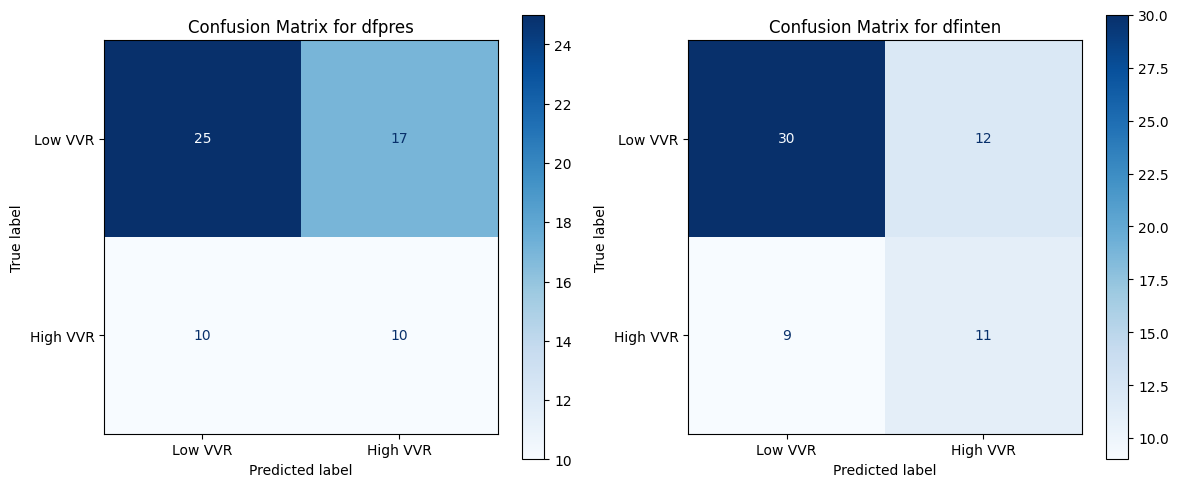

In [13]:
# Generate confusion matrices
cm_pres = confusion_matrix(ypres_test, ypres_pred_test)
cm_inten = confusion_matrix(yinten_test, yinten_pred_test)

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion matrix for dfpres
disp_pres = ConfusionMatrixDisplay(confusion_matrix=cm_pres, display_labels=['Low VVR', 'High VVR'])
disp_pres.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix for dfpres')

# Confusion matrix for dfinten
disp_inten = ConfusionMatrixDisplay(confusion_matrix=cm_inten, display_labels=['Low VVR', 'High VVR'])
disp_inten.plot(ax=axes[1], cmap='Blues', values_format='d')
axes[1].set_title('Confusion Matrix for dfinten')

# Adjust layout
plt.tight_layout()
plt.show()
